In [33]:
import boto3
import pandas as pd
from io import BytesIO
import os

# Specify your S3 bucket name
bucket_name = 'asilitechtimeseriesforecastdata'

# Create an S3 client
s3_client = boto3.client('s3')

# List objects in the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name)

# Initialize variables for the data
csv_data = None
excel_data = None

# Loop through each object in the bucket
for obj in response.get('Contents', []):
    # Get the object key
    object_key = obj['Key']

    # Download the file from S3
    response = s3_client.get_object(Bucket=bucket_name, Key=object_key)

    # Read the content based on file extension (csv or excel)
    if object_key.lower().endswith('.csv'):
        csv_data = pd.read_csv(response['Body'])
    elif object_key.lower().endswith(('.xls', '.xlsx')):
        # Create a seekable BytesIO buffer for Excel files
        excel_data = pd.read_excel(BytesIO(response['Body'].read()))
    else:
        # Handle other file types if needed
        continue

# Print or process the data as needed
if csv_data is not None:
    print("Content of CSV file:")
    print(csv_data.head())
    # Save the CSV data to a local file (optional)
    csv_data.to_csv('csv_data.csv', index=False)
    print("CSV data saved to csv_data.csv\n")

if excel_data is not None:
    print("Content of Excel file:")
    print(excel_data.head())
    # Save the Excel data to a local file (optional)
    excel_data.to_excel('excel_data.xlsx', index=False)
    print("Excel data saved to excel_data.xlsx\n")


Content of CSV file:
   Year Month  Volume Horticulture  (Tonnes)  \
0  2007   Jan                       17112.39   
1  2007   Feb                       18905.81   
2  2007   Mar                       24796.49   
3  2007   Apr                       22748.93   
4  2007   May                       22885.72   

   Average Horticulture (Kshs. per Tonne)  Annual Average Inflation   \
0                               188541.52                       6.08   
1                               175393.06                       5.55   
2                               148545.24                       4.99   
3                               168518.27                       4.69   
4                               168111.86                       4.47   

   Diaspora Remittances  Euro ex  Sterling Pound ex  US ex  CB Deposit  \
0              40930.36    90.87             136.91  69.89        4.35   
1              39533.07    91.04             136.40  69.62        4.21   
2              48561.00    91.77   

In [35]:
train = csv_data
test = excel_data

In [36]:
train = train[['date','Year', 'Month', 'Volume Horticulture  (Tonnes)',
       'Average Horticulture (Kshs. per Tonne)', 'Annual Average Inflation ']]

In [37]:
test = test[['date','Year', 'Month', 'Volume Horticulture  (Tonnes)',
       'Average Horticulture (Kshs. per Tonne)', 'Annual Average Inflation']]

In [38]:
test.head()

,date,Year,Month,Volume Horticulture (Tonnes),Average Horticulture (Kshs. per Tonne),Annual Average Inflation
0,2022-01-01,2022,January,47984.19,220564.955,6.08
1,2022-02-01,2022,February,41351.44,259547.960,6.23
2,2022-03-01,2022,March,49557.36,229576.510,6.29
3,2022-04-01,2022,April,49975.74,209350.540,6.05
4,2022-05-01,2022,May,49516.59,238974.850,6.16


In [39]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [40]:
train.head()

,Year,Month,Volume Horticulture (Tonnes),Average Horticulture (Kshs. per Tonne),Annual Average Inflation
date,,,,,
2007-01-01,2007,Jan,17112.39,188541.52,6.08
2007-02-01,2007,Feb,18905.81,175393.06,5.55
2007-03-01,2007,Mar,24796.49,148545.24,4.99
2007-04-01,2007,Apr,22748.93,168518.27,4.69
2007-05-01,2007,May,22885.72,168111.86,4.47


In [41]:
from basicTimeSeries import SARIMAModels

ts = SARIMAModels()

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2007-01-01 to 2021-12-01
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Year                                    180 non-null    int64  
 1   Month                                   180 non-null    object 
 2   Volume Horticulture  (Tonnes)           180 non-null    float64
 3   Average Horticulture (Kshs. per Tonne)  180 non-null    float64
 4   Annual Average Inflation                180 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 8.4+ KB


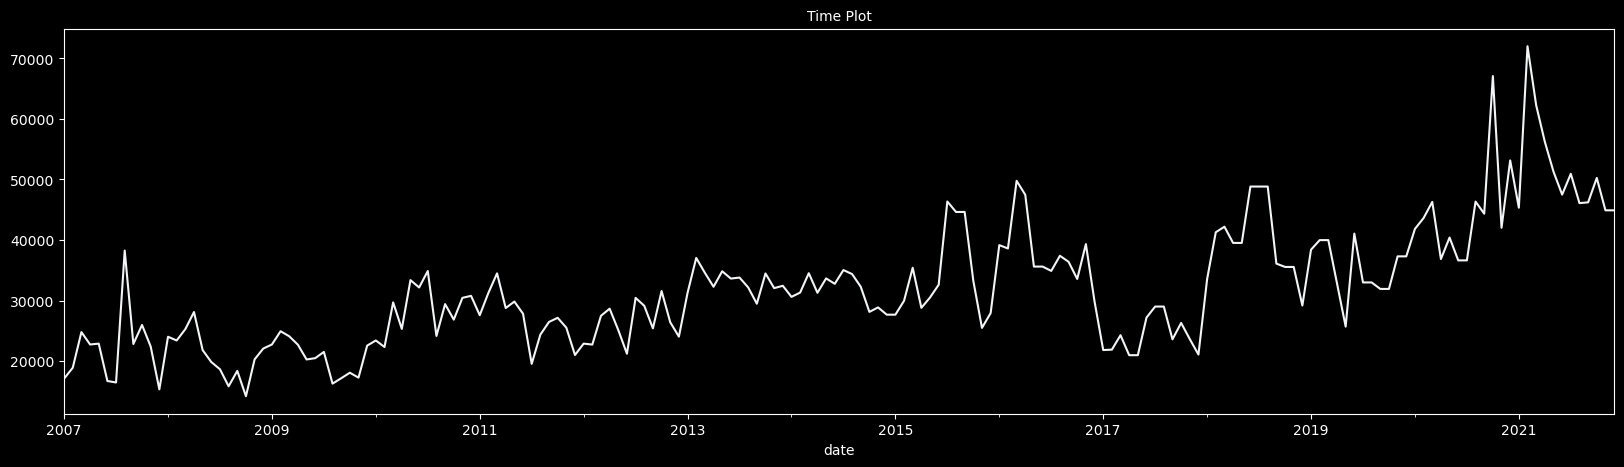

In [43]:
ts.trend_visualizations(train['Volume Horticulture  (Tonnes)'])

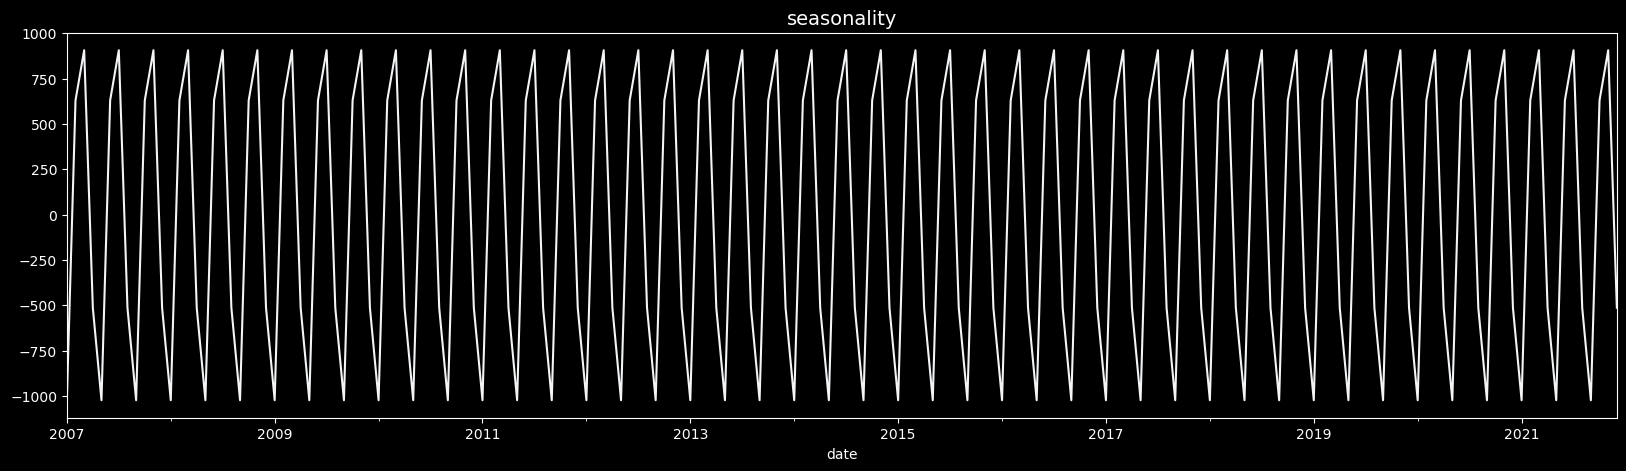

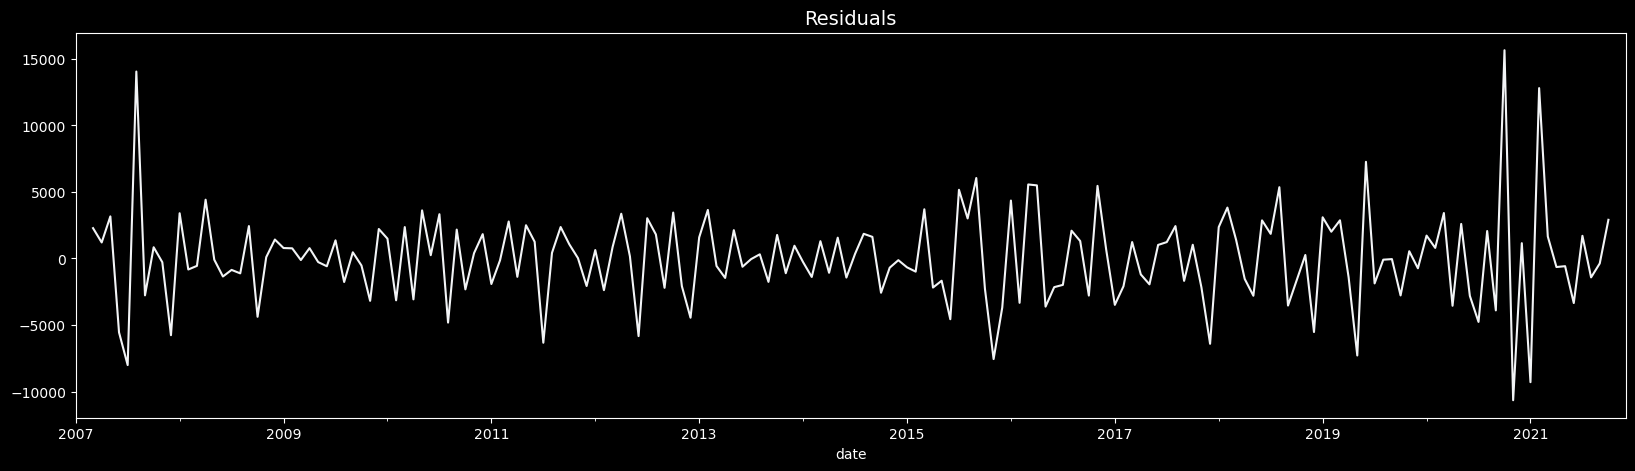

In [44]:
ts.decomposition_plot(train['Volume Horticulture  (Tonnes)'], period=4)

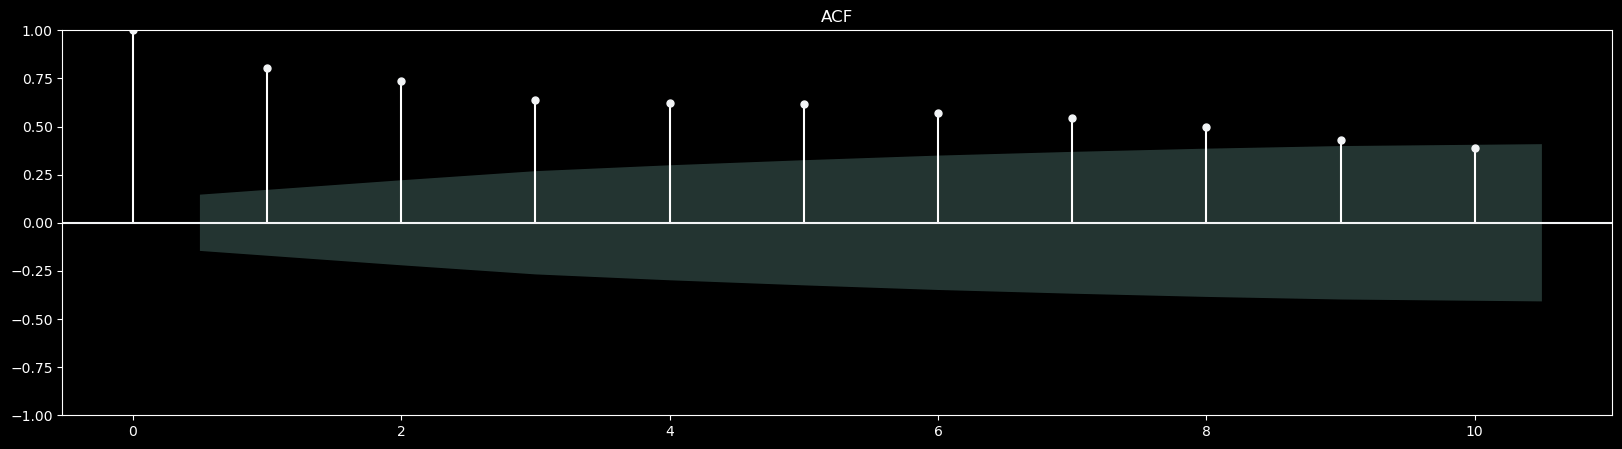

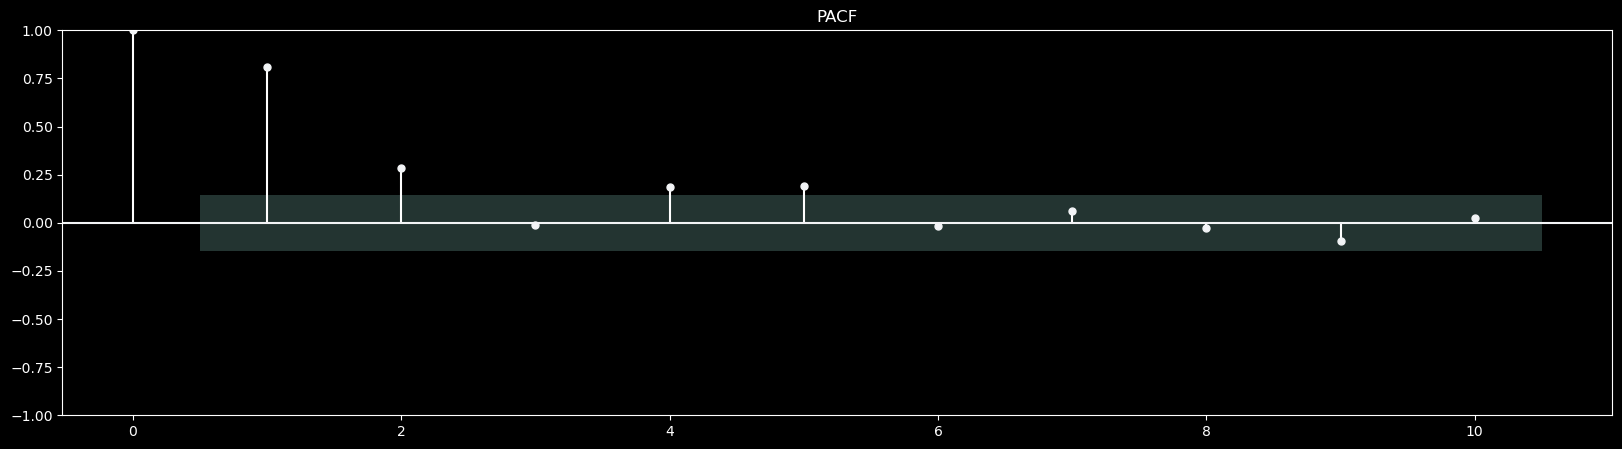

In [45]:
ts.correlation_function(train['Volume Horticulture  (Tonnes)'])

In [46]:
ts.stationarity_check(train['Volume Horticulture  (Tonnes)'])

Augmented Dickey Fuller Test 

null-hypothesis: The data is non-stationary
alternative-hypothesis: The data is stationary 
 -----------------------------------------------
p-value:                = 0.36033367083963597
test-statistic:         = -1.8409402004305402
Number of lag chosen:   = 4
observation:            = 175
critical-values:        = {'1%': -3.4682803641749267, '5%': -2.8782017240816327, '10%': -2.5756525795918366}
maximized-criteria:     = 3310.564376482536
=> The data is non-stationary.The p-value is 0.36 thus we fail to reject the null hypothesis


----------------------------------------------- 
 ----------------------------------------------- 

KPSS Test for Stationarity 

H0: The time series data is stationary
H1:The time series data is non-stationary 
 -----------------------------------------------
KPSS Statistic: =1.4705875372611854
p-value:        =0.01
num lags:       =8
Critial Values:
   10% :  =0.347
   5% :  =0.463
   2.5% :  =0.574
   1% :  =0.739
Result: Th

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63006D+00    |proj g|=  8.53127D-02

At iterate    5    f=  8.62266D+00    |proj g|=  4.09800D-04

At iterate   10    f=  8.62266D+00    |proj g|=  1.19850D-03

At iterate   15    f=  8.62252D+00    |proj g|=  1.69347D-02

At iterate   20    f=  8.60411D+00    |proj g|=  1.83000D-01

At iterate   25    f=  8.56038D+00    |proj g|=  2.89407D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     33      1     0     0   

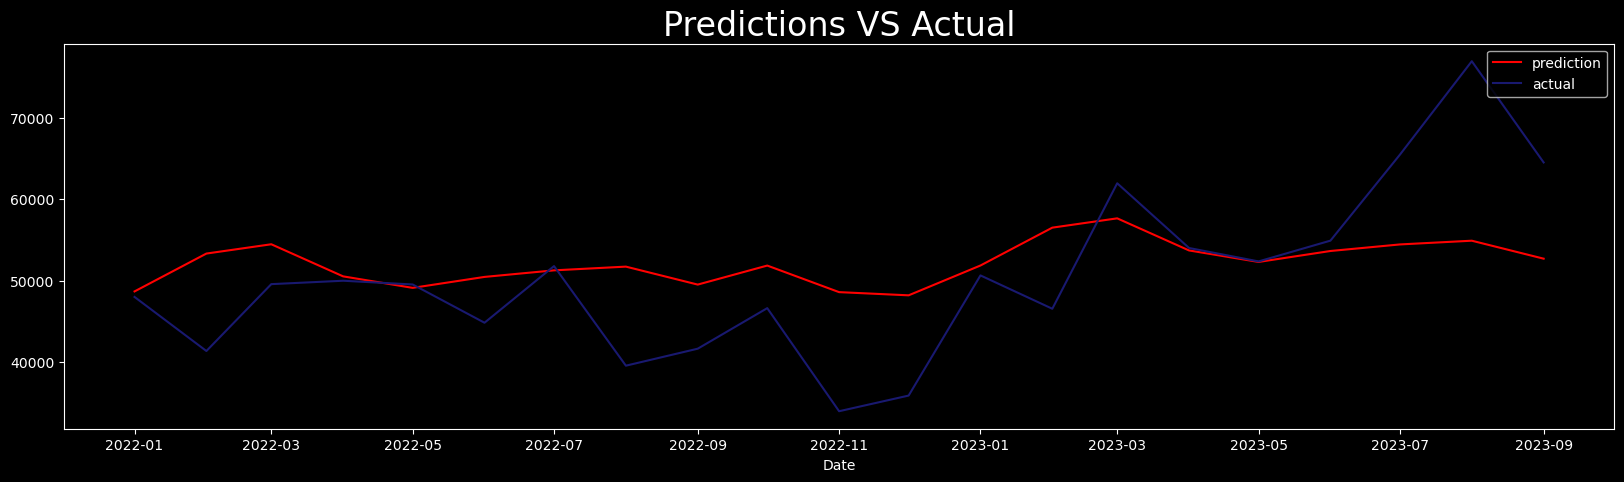

In [47]:
residuals = ts.best_model(train['Volume Horticulture  (Tonnes)'],
              test['Volume Horticulture  (Tonnes)'],
              order=(0,1,1), seasonal_order=(0,1,1,12), lags=5)

In [48]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

df = pd.concat([train[['Volume Horticulture  (Tonnes)', "date"]], 
               test[['Volume Horticulture  (Tonnes)', "date"]]])
df.set_index("date", inplace=True)

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83012D+00    |proj g|=  1.16007D-01

At iterate    5    f=  8.81900D+00    |proj g|=  1.53768D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   5.015D-05   8.819D+00
  F =   8.8189967009761059     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


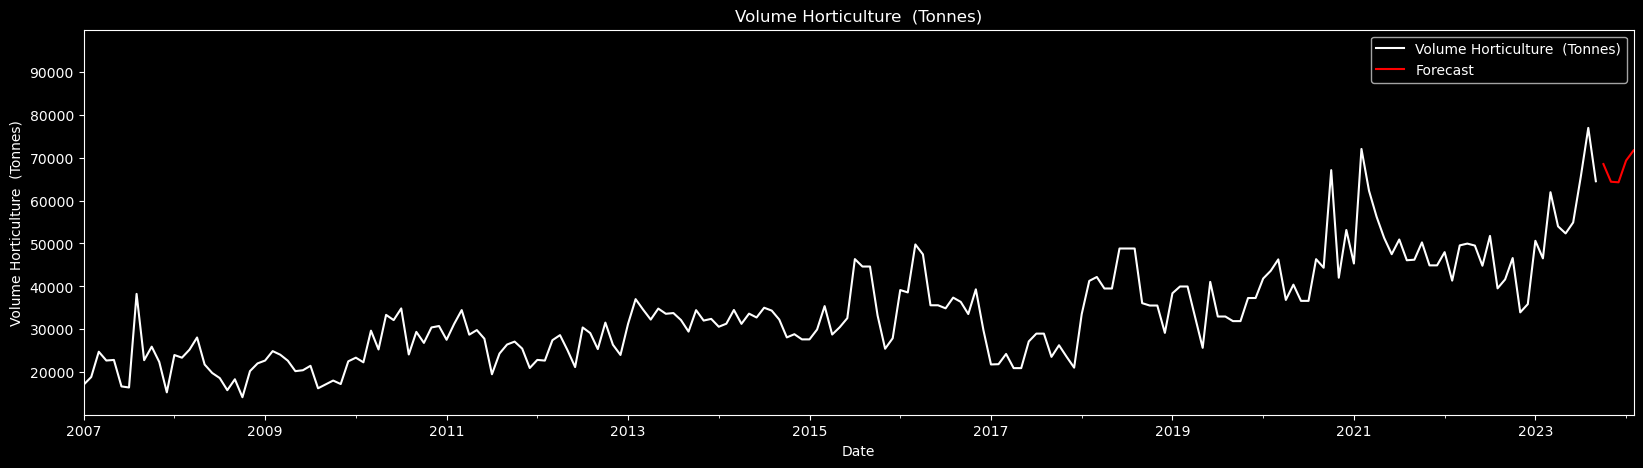

In [49]:
forecast = ts.forecasts(df, order=(0,1,1), seasonal_order=(0,1,1,12), steps=5)

In [50]:
forecast.values[:,0]

array([68500.01626805, 64377.2355181 , 64249.07787652, 69320.74759059,
       71690.62295064])

In [51]:
forecast.index

DatetimeIndex(['2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01',
               '2024-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [52]:
forecast_values = pd.DataFrame({'Volume Horticulture  (Tonnes)': forecast.values[:,0],
                               'date': forecast.index})

# forecast_values.set_index('date', inplace=True)
forecast_values

,Volume Horticulture (Tonnes),date
0,68500.016268,2023-10-01
1,64377.235518,2023-11-01
2,64249.077877,2023-12-01
3,69320.747591,2024-01-01
4,71690.622951,2024-02-01


In [55]:
df.reset_index(inplace=True)

In [59]:
all_data = pd.concat([df, forecast_values])

In [61]:
all_data.reset_index(drop=True, inplace=True)

In [62]:
all_data

,date,Volume Horticulture (Tonnes)
0,2007-01-01,17112.390000
1,2007-02-01,18905.810000
2,2007-03-01,24796.490000
3,2007-04-01,22748.930000
4,2007-05-01,22885.720000
...,...,...
201,2023-10-01,68500.016268
202,2023-11-01,64377.235518
203,2023-12-01,64249.077877
204,2024-01-01,69320.747591


In [63]:
import boto3
import pandas as pd
from io import StringIO

# Specify your S3 bucket name
bucket_name = 'asilitechtimeseriesforecastdata'

# Create an S3 client
s3_client = boto3.client('s3')
# Convert DataFrame to CSV string
csv_buffer = StringIO()
df.to_csv(csv_buffer, index=False)
forecast_values.to_csv(csv_buffer, index=False)
all_data.to_csv(csv_buffer, index=False)

# Specify the S3 key and object name
s3_key1 = 'output/actual.csv'
s3_key2 = 'output/forecast.csv'
s3_key3 = 'output/alldata.csv'

# Upload the CSV file to S3
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key1)
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key2)
s3_client.put_object(Body=csv_buffer.getvalue(), Bucket=bucket_name, Key=s3_key3)

print(f"CSV file saved to S3 bucket '{bucket_name}' with key '{s3_key1}'")
print(f"CSV file saved to S3 bucket '{bucket_name}' with key '{s3_key2}'")
print(f"CSV file saved to S3 bucket '{bucket_name}' with key '{s3_key3}'")

CSV file saved to S3 bucket 'asilitechtimeseriesforecastdata' with key 'output/actual.csv'
CSV file saved to S3 bucket 'asilitechtimeseriesforecastdata' with key 'output/forecast.csv'
CSV file saved to S3 bucket 'asilitechtimeseriesforecastdata' with key 'output/alldata.csv'
